<div style="font-size:1.4em; margin-bottom:2em">
    <div style="float:right; line-height:1.2em;">GET Lab<br />Paderborn University</div>
  <div>SS 2021</div>
</div>
<div style="clear:both"></div>
<div style="text-align:center; font-size:1.8em;">
  Digital Image Processing II<br />Task Sheet 12
</div>

<hr>

### Overview

The objective of this task sheet is to implement and test the perceptron to classify different subsets of the classic <a href="https://archive.ics.uci.edu/ml/datasets/Iris">Iris Data Set</a> using the *Least-Mean-Squared-Error* (LMSE) algorithm. The perceptron distinguishes two classes, $c_1 \hat{=} +1$ and $c_2 \hat{=} -1$, and is structured as follows:

<center><img src="images/perceptron.png" width="300px" style="margin:10px;" /></center>

If we add a 1 at the end of each $n$-dimensional feature vector and the bias $w_{n+1}$ at the end of the weight vector (*augmentation*), we get $\mathbf{x} = [x_1, x_2, \dots, x_n, 1]^T$ and $\mathbf{w} = [w_1, w_2, \dots, w_n, w_{n+1}]^T$, respectively. Then, the sum of products and the bias (together they represent a hyperplane) and the classification can be written in a compact form as follows:

$$
\mathbf{w}^T \mathbf{x} =
\begin{cases}
> 0, & \text{if } \mathbf{x}\in c_1\\
< 0, & \text{if } \mathbf{x}\in c_2
\end{cases}
$$

The objective is now to determine the augmented weight vector $\mathbf{w}$ to learn a decision boundary. The classic *perceptron training algorithm* requires linearly separable classes, the LMSE algorithm does not have this restriction. The algorithm uses the following error function:

$$
E(\mathbf{w}) = \frac{1}{2} (r-\mathbf{w}^T \mathbf{x})^2
$$

In this equation, $r = \pm 1$ represents the desired class of $\mathbf{x}$. Note that $E$ is constructed so that it is differentiable and has a unique minimum. The minimum can then be determined using an iterative gradient descent algorithm, which leads to the following iterative update scheme:

$$
\mathbf{w}(k+1) = \mathbf{w}(k) + \alpha \left[r(k) - \mathbf{w}^T(k) \mathbf{x}(k)\right] \mathbf{x}(k) 
$$

In this equation, $\alpha > 0$ is the *learning rate* in a typical range of $0.001 < \alpha < 1.0$. The initial weight vector is often chosen as $\mathbf{w}(1) = \mathbf{0}$. To determine $\mathbf{w}$ during the training, the training feature vectors are cycled through this equation. One complete iteration trough *all* training examples is called an *epoch*.

---

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

dpi = plt.rcParams['figure.dpi']

# plot image in original size
def plot_img_orig(img):
    fig = plt.figure(figsize = (img.shape[1]/dpi, img.shape[0]/dpi))
    fig.add_axes([0, 0, 1, 1])
    plt.axis('off')
    plt.imshow(img, cmap='gray', vmin=0, vmax=255) # cmap parameter is ignored for RGB(A) data
    plt.show()

#### <span style="color: RoyalBlue; font-weight: bold;">Task 12.1</span> Least-Mean-Squared-Error (LMSE) Algorithm

The Iris Data Set contains the length and the width of the sepal and petal leaves (in centimeters) of three iris flower species: *Iris setosa*, *Iris versicolor*, and *Iris virginica*. Only the samples from *Iris setosa* are linearly separable from the other two classes when using $n$-dimensional feature vectors and $n \geq 2$. There are 50 sets of measurements for each of the three species so that are 150 sets in total. In the data set file provided (*iris.csv*), the measurements are arranged in a sequence in the order *setosa*, *versicolor*, and *virginica*.

The measurements (features) are ordered in lines as follows:

$$\text{line}_i = \left[\text{sepal length}, \text{sepal width}, \text{petal length}, \text{petal width}, \text{class}\right]$$

The following example is in 2D for easy plotting but can be directly extended to 4D so that all features are used. 

Implement / solve the following tasks:
1. Plot all feature vectors from the three classes in a 2D feature space using $x_1 = \text{sepal length}$ and $x_2 = \text{sepal width}$.
2. Implement the algorithm from the overview to compute $\mathbf{w}(k+1)$ based on the two classes *setosa* and *versicolor*.
3. Compute the corresponding decision boundary using $1000$ epochs and $\alpha = 0.001$ and plot it after every 10th epoch.
4. Compute $E(\mathbf{w})$ at the end of each epoch for each $\mathbf{x}$, sum it up, and divide it by the number of feature vectors. This gives the mean squared error.
5. Plot the mean squared error as a function of the epochs.
6. Compute and plot the squared error $E(\mathbf{w})$ for one feature vector from $c_1$ after every 10th epoch as a function of $\mathbf{w}^T \mathbf{x}$.

Feature space with decision boundaries:


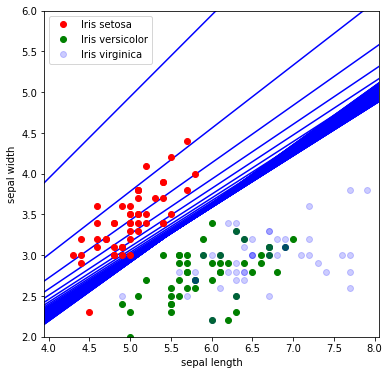

Mean squared error as a function of the epochs:


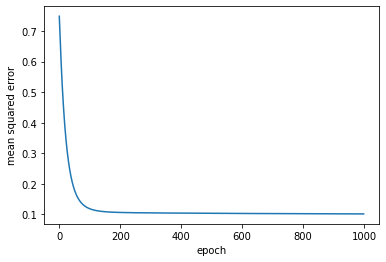

Squared error for one feature vector from c1:


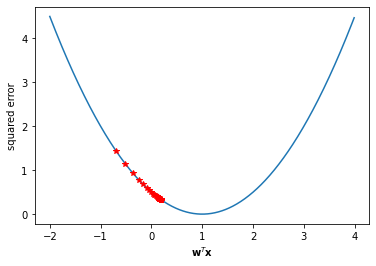

In [2]:
# write your code here

# import data from CSV file (names in last col will be read as not a number, nan)
iris_data = np.genfromtxt('dataset/iris.csv', delimiter=',')
#print(iris_data)

# exemplary plot (change slicing for other feature configurations)
plt.figure(figsize=(6, 6))

plt.plot(iris_data[0:50, 0], iris_data[0:50, 1], 'ro', label='Iris setosa')
plt.plot(iris_data[50:100, 0], iris_data[50:100, 1], 'go', label='Iris versicolor')
plt.plot(iris_data[100:150, 0], iris_data[100:150, 1], 'bo', alpha=0.2, label='Iris virginica')

plt.xlabel("sepal length"); plt.ylabel("sepal width")
plt.axis("equal")
plt.xlim(4, 8); plt.ylim(2, 6)
plt.legend()
#plt.show()

# parameters and initialization
w_last = np.array([0, 0, 0]) # we use 2D features and augmentation, therefore 3 entries
alpha = 0.001
n_epochs = 1000

c1 = iris_data[0:50, 0:3] # class c1 (+1)
c2 = iris_data[50:100:, 0:3] # class c2 (-1)

c1[:, 2] = 1 # augmentation (replace third feature with 1)
c2[:, 2] = 1

# array to store the mean squared error
mse = np.zeros(n_epochs)

# array to store the squared error for the first feature vector from c1
se_c1 = np.zeros(n_epochs)

# k indicates the current epoch
for k in range(n_epochs):
    # update of w(k+1) for one epoch
    for i in range(len(c1)): # class c1
        w_current = w_last + alpha*((+1)-np.dot(np.transpose(w_last), c1[i,:]))*c1[i,:]
        w_last = w_current

    for i in range(len(c2)): # class c1
        w_current = w_last + alpha*((-1)-np.dot(np.transpose(w_last), c2[i,:]))*c2[i,:]
        w_last = w_current
        
    # compute and sum up the errors corresponding to the error function
    for i in range(len(c1)): # class c1
        mse[k] = mse[k] + 0.5*np.square(((+1)-np.dot(np.transpose(w_last), c1[i,:])))

    for i in range(len(c2)): # class c1
        mse[k] = mse[k] + 0.5*np.square(((-1)-np.dot(np.transpose(w_last), c2[i,:])))
        
    # compute the mean squared error
    mse[k] = mse[k] / (len(c1) + len(c2))
    
    # compute the squared error for the first feature vector from c1
    se_c1[k] = np.dot(np.transpose(w_last), c1[1,:])

# plot the current decision boundary every 100 epochs
    if (k % 10) == 0:
    #if k == 10:
        x1 = np.arange(0, 10, 0.1)
        x2 = -(w_last[0]/w_last[1])*x1 - (w_last[2]/w_last[1])
        plt.plot(x1, x2, 'b', zorder=1)

# final plot with decision boundaries
print("Feature space with decision boundaries:")
plt.show()

# plot of the mean squared error as a function of the epochs
print("Mean squared error as a function of the epochs:")
plt.plot(mse)
plt.xlabel("epoch"); plt.ylabel("mean squared error")
plt.show()

# general form of the error function
wx = np.arange(-2, 4, 0.01)
E = 0.5*(1-wx)*(1-wx)
plt.plot(wx, E)

# squared error for the first feature vector from c1
E = 0.5*(1-se_c1)*(1-se_c1)
plt.plot(se_c1[::10], E[::10], 'r*') # plot every 10th value

plt.xlabel("$\mathbf{w}^T\mathbf{x}$"); plt.ylabel("squared error")
print("Squared error for one feature vector from c1:")
plt.show()

Note that the error is minimized, but this does not necessarily mean that there are no more false classifications. In particular, the mean squared error is not directly proportional to the rate of false classifications. Both the systematic refinement of the decision boundary and the decreasing errors (the last two plots) show that the algorithm converges to a good solution.